# eSafety Hackathon - Data Exploration

This notebook provides a starting point for exploring the hackathon data.

## Setup

In [2]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys
sys.path.append('..')

# Our utilities
from src.utils.text_utils import clean_text, count_features, detect_patterns, extract_emojis

# Display settings
pd.set_option('display.max_colwidth', 200)
plt.style.use('seaborn-v0_8-whitegrid')

print("Setup complete! ✅")

Setup complete! ✅


## Load Data

Loading the competition training data (42,031 labeled examples from competition_train.jsonl)

In [ ]:
# Load competition training data (JSONL format)
import json

DATA_PATH = '../data/raw/competition_train.jsonl'

# Load JSONL data
data = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

print(f"Loaded {len(df):,} messages")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)

# Show category distribution
all_categories = []
for labels in df['category_labels']:
    all_categories.extend(labels)

from collections import Counter
cat_counts = Counter(all_categories)

print(f"\n{'='*60}")
print("CATEGORY DISTRIBUTION:")
print(f"{'='*60}")
for cat, count in cat_counts.most_common():
    pct = (count / len(df)) * 100
    print(f"  {cat:20s}: {count:6,} ({pct:5.2f}%)")

print(f"\nFirst 3 examples:")
df.head(3)

## Basic Statistics

In [ ]:
# Basic stats
print(f"Total messages: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")

# Check for multi-label examples
multi_label_count = sum(1 for labels in df['category_labels'] if len(labels) > 1)
print(f"\nMulti-label examples: {multi_label_count:,} ({(multi_label_count/len(df))*100:.2f}%)")

# Post type distribution
print(f"\nPost type distribution:")
print(df['type'].value_counts())

# Messages per user
user_msg_counts = df['user_id'].value_counts()
print(f"\nMessages per user:")
print(user_msg_counts.describe())

In [7]:
# Extract text features
df['features'] = df['text'].apply(count_features)

# Expand features into columns
features_df = pd.json_normalize(df['features'])
df = pd.concat([df, features_df], axis=1)

# Show feature distributions
print("Text Feature Statistics:")
df[['word_count', 'emoji_count', 'caps_ratio', 'exclamation_count']].describe()

Text Feature Statistics:


,word_count,emoji_count,caps_ratio,exclamation_count
count,5.000000,5.000000,5.000000,5.000000
mean,11.400000,0.600000,0.084871,0.400000
std,3.646917,0.547723,0.051235,0.547723
min,7.000000,0.000000,0.038462,0.000000
25%,9.000000,0.000000,0.039216,0.000000
50%,11.000000,1.000000,0.068182,0.000000
75%,14.000000,1.000000,0.133333,1.000000
max,16.000000,1.000000,0.145161,1.000000


## Pattern Detection

In [9]:
# Detect patterns
df['patterns'] = df['text'].apply(detect_patterns)

# Show which patterns were detected
for idx, row in df.iterrows():
    detected = [k for k, v in row['patterns'].items() if v]
    if detected:
        print(f"Message {row['id']}: {detected}")
        print(f"  Text: {row['text'][:100]}...\n")

Message 1: ['shouting']
  Text: I just landed my DREAM job after being rejected 47 times. Never give up! Agree? 🚀...

Message 5: ['humble_brag', 'thought_leadership', 'shouting']
  Text: I'm HUMBLED to announce I've been selected as a thought leader in disruption. 🙏...



## User-Level Analysis

For persona classification, we might want to aggregate at the user level.

In [ ]:
# Aggregate by user
user_stats = df.groupby('user_id').agg({
    'text': 'count',
    'word_count': 'mean',
    'emoji_count': 'sum',
    'exclamation_count': 'sum',
    'caps_ratio': 'mean'
}).rename(columns={'text': 'message_count'})

# Add dominant category for each user
def get_dominant_category(user_df):
    all_cats = []
    for labels in user_df['category_labels']:
        all_cats.extend(labels)
    if all_cats:
        return Counter(all_cats).most_common(1)[0][0]
    return 'unknown'

user_stats['dominant_category'] = df.groupby('user_id').apply(get_dominant_category)

print(f"User-level statistics:")
print(user_stats.head(10))

print(f"\nDominant category distribution across users:")
print(user_stats['dominant_category'].value_counts())

## Visualization

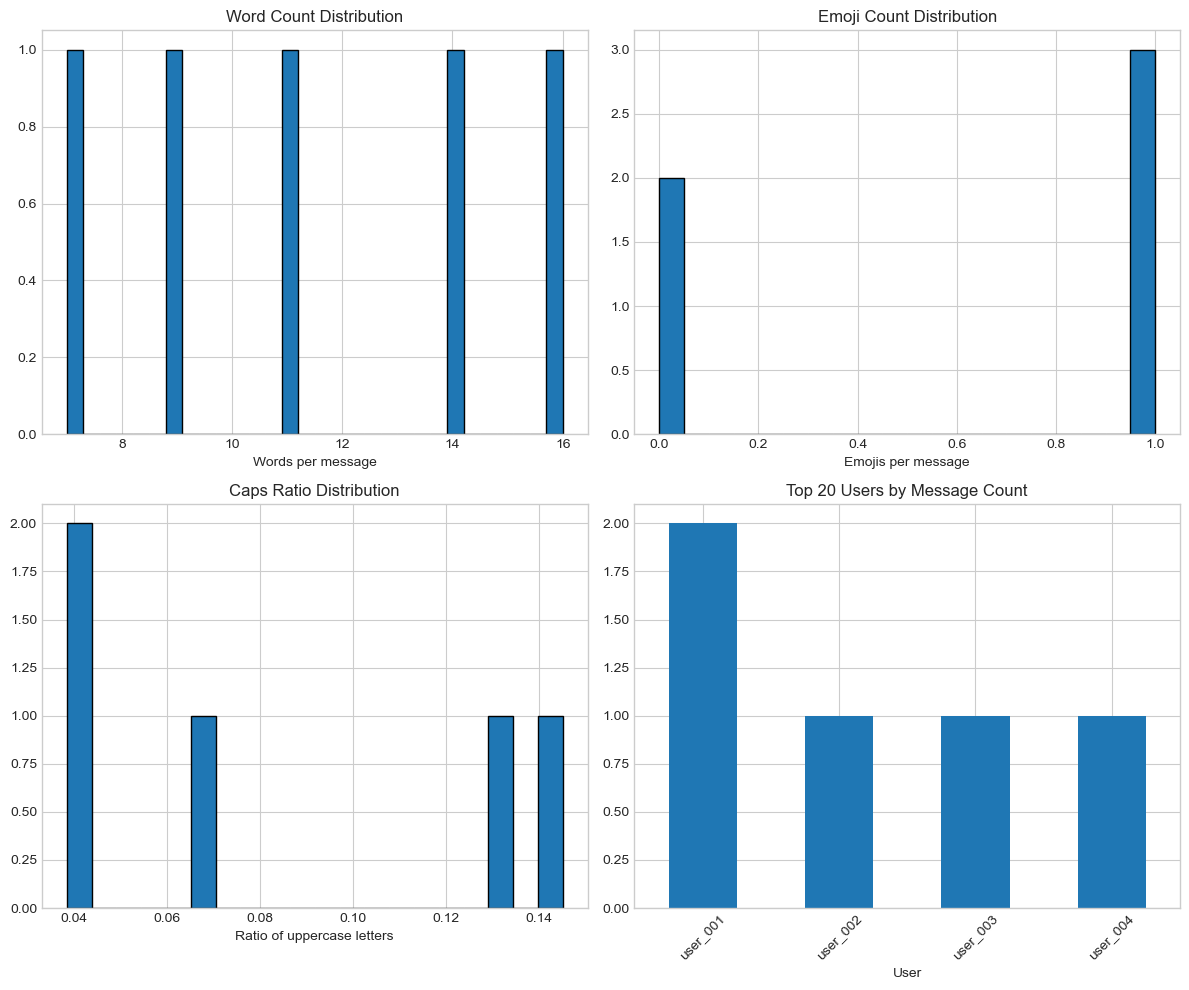

In [13]:
# Word count distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(df['word_count'], bins=30, edgecolor='black')
axes[0, 0].set_title('Word Count Distribution')
axes[0, 0].set_xlabel('Words per message')

axes[0, 1].hist(df['emoji_count'], bins=20, edgecolor='black')
axes[0, 1].set_title('Emoji Count Distribution')
axes[0, 1].set_xlabel('Emojis per message')

axes[1, 0].hist(df['caps_ratio'], bins=20, edgecolor='black')
axes[1, 0].set_title('Caps Ratio Distribution')
axes[1, 0].set_xlabel('Ratio of uppercase letters')

# Messages per user
df['user'].value_counts().head(20).plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Top 20 Users by Message Count')
axes[1, 1].set_xlabel('User')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Most Common Words/Phrases

In [15]:
from collections import Counter
import re

# Get all words
all_text = ' '.join(df['text'].apply(lambda x: clean_text(x, remove_punctuation=True)))
words = all_text.split()

# Filter out common stop words
stop_words = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
              'to', 'of', 'and', 'in', 'that', 'it', 'for', 'on', 'with', 'as', 'at',
              'by', 'this', 'from', 'or', 'but', 'not', 'you', 'your', 'i', 'my', 'me',
              'we', 'our', 'they', 'their', 'he', 'she', 'his', 'her', 'have', 'has'}

filtered_words = [w for w in words if w not in stop_words and len(w) > 2]

print("Top 30 words:")
for word, count in Counter(filtered_words).most_common(30):
    print(f"  {word}: {count}")

Top 30 words:
  like: 2
  just: 1
  landed: 1
  dream: 1
  job: 1
  after: 1
  rejected: 1
  times: 1
  never: 1
  give: 1
  agree: 1
  wish: 1
  could: 1
  look: 1
  skipped: 1
  lunch: 1
  again: 1
  today: 1
  had: 1
  great: 1
  coffee: 1
  morning: 1
  nobody: 1
  understands: 1
  society: 1
  rigged: 1
  against: 1
  people: 1
  humbled: 1
  announce: 1


## Next Steps

1. **Run the classification notebook** (`02_classification.ipynb`) to test different approaches
2. **Explore user patterns** - Do certain users consistently post in specific styles?
3. **Look for clusters** - Use embeddings to group similar messages
4. **Check for temporal patterns** - If timestamps available, look for posting patterns

In [ ]:
# Show 2 examples per category
shown_per_cat = {}
print("="*80)
print("CATEGORY EXAMPLES (2 per category)")
print("="*80)

for idx, row in df.iterrows():
    for cat in row['category_labels']:
        if shown_per_cat.get(cat, 0) < 2:
            shown_per_cat[cat] = shown_per_cat.get(cat, 0) + 1
            text = row['text'][:150] + ('...' if len(row['text']) > 150 else '')
            print(f"\n[{cat.upper()}]")
            print(f"  User: {row['user_id']}, Type: {row['type']}")
            print(f"  Text: {text}")
    
    # Stop once we have 2 examples of each category
    if all(count >= 2 for count in shown_per_cat.values()) and len(shown_per_cat) >= 10:
        break

## Category Examples

Let's look at some examples from each category to understand the patterns.